In [2]:
import NO_utils
import os
import matplotlib.pyplot as plt
import numpy as np
import random

## Load and visualize data

OUTPUT\discrete_symmetric_p32_n400_rs0
Data loaded in 314.88 seconds.
Spatial waves shape: (400, 325, 32, 32)
n_designs: 400, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[0.]]
EIGENVALUE_DATA shape: (400, 325, 6)
EIGENVECTOR_DATA shape: (400, 325, 6, 2048)
EIGENVECTOR_DATA_x shape: (400, 325, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (400, 325, 6, 32, 32)
WAVEVECTOR_DATA shape: (400, 325, 2)
WAVEFORM_DATA shape: (400, 325, 32, 32)
designs shape: (400, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'isSaveEigenvectors': (1, 1), 'isUseGPU': (1, 1), 'isUseImprovement': (1, 1), 'isUseParallel': (1, 1), 'isUseSecondImprovement': (1, 1), 'poisson_max': (1, 1), 'poisson_min': (1, 1), 'rho_max': (1, 1), 'rho_min': (1, 1), 'sigma_eig': (1, 1), 'symmetry_type': (4, 1), 't': (1, 1), 'wavevectors': (2, 

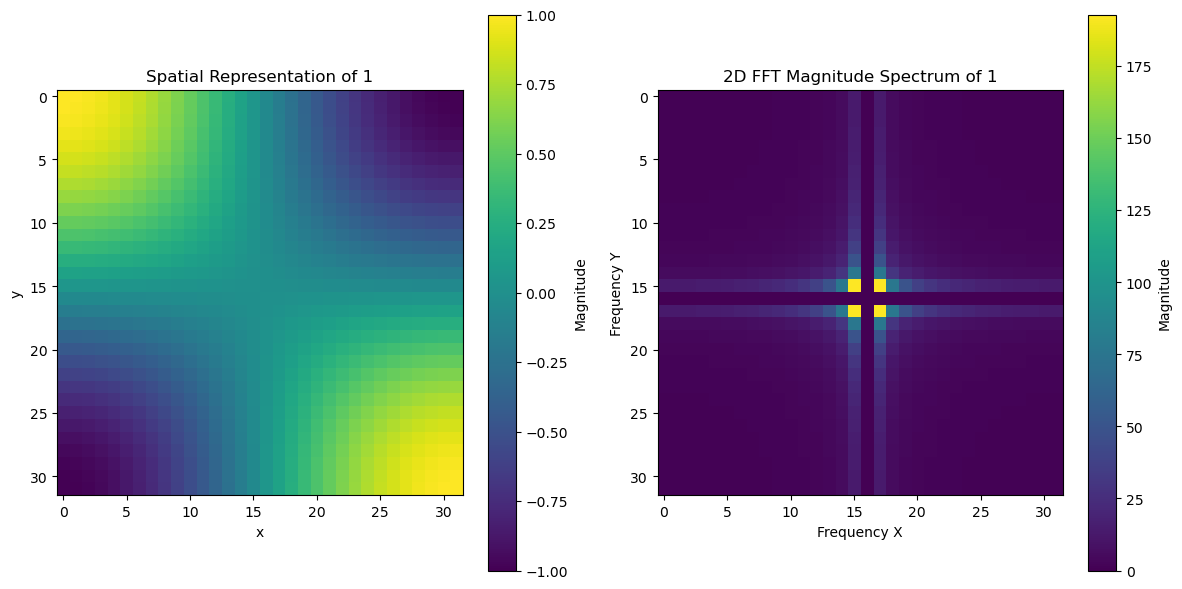

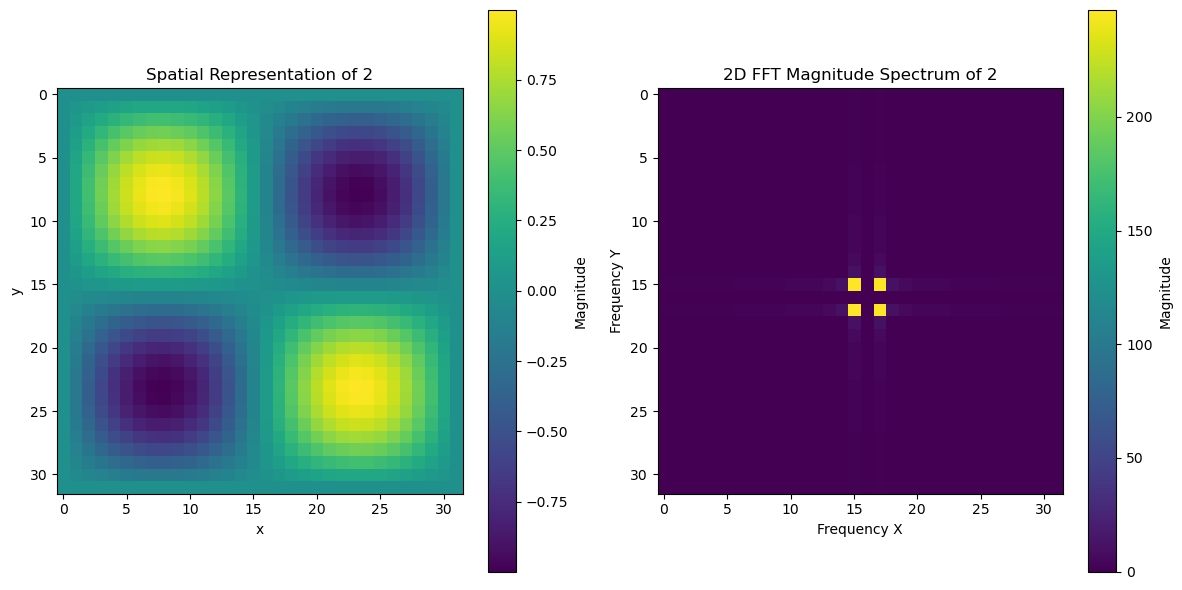

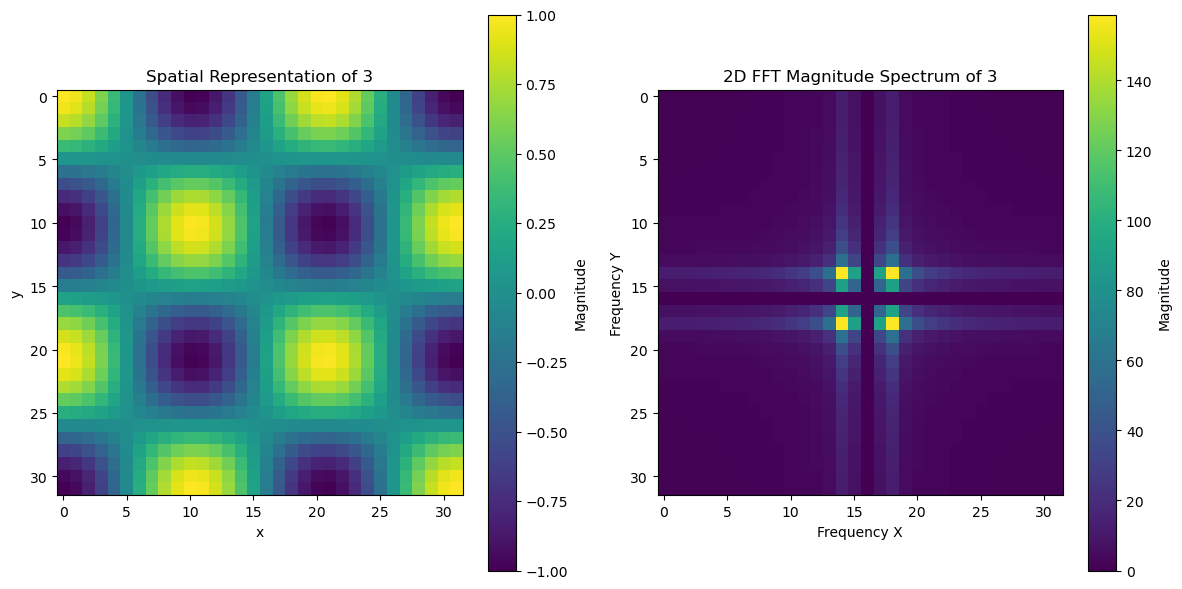

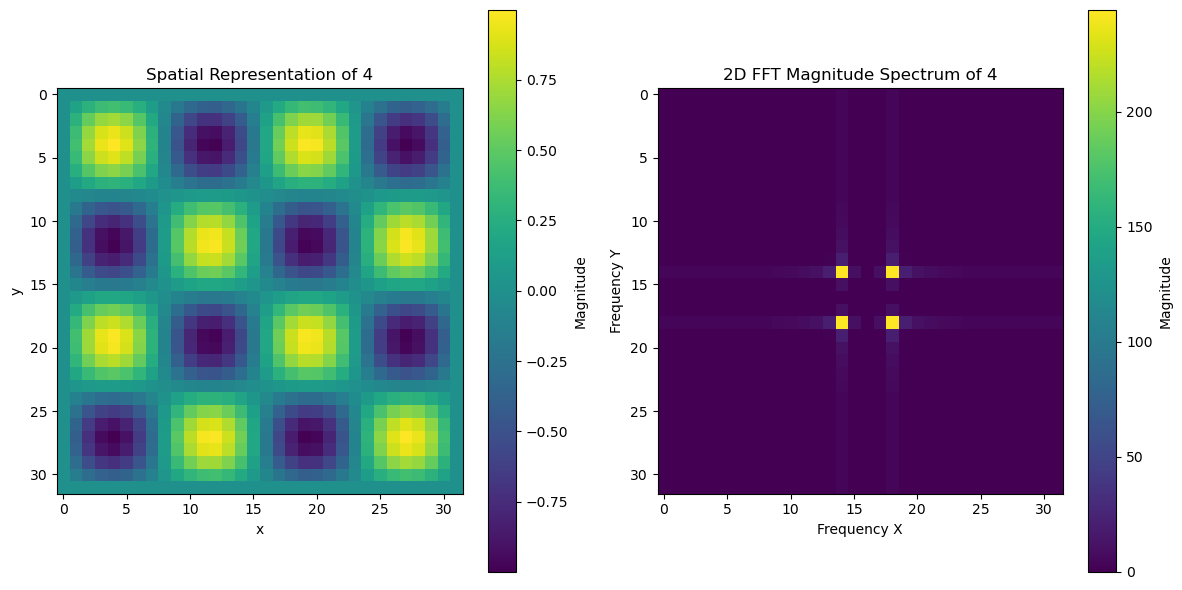

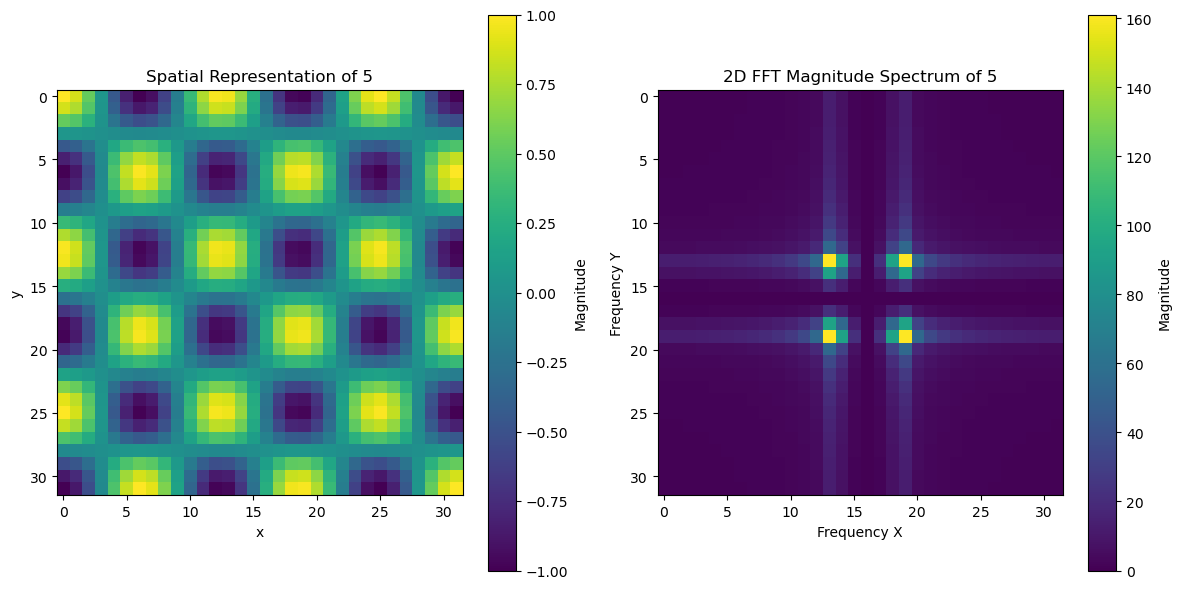

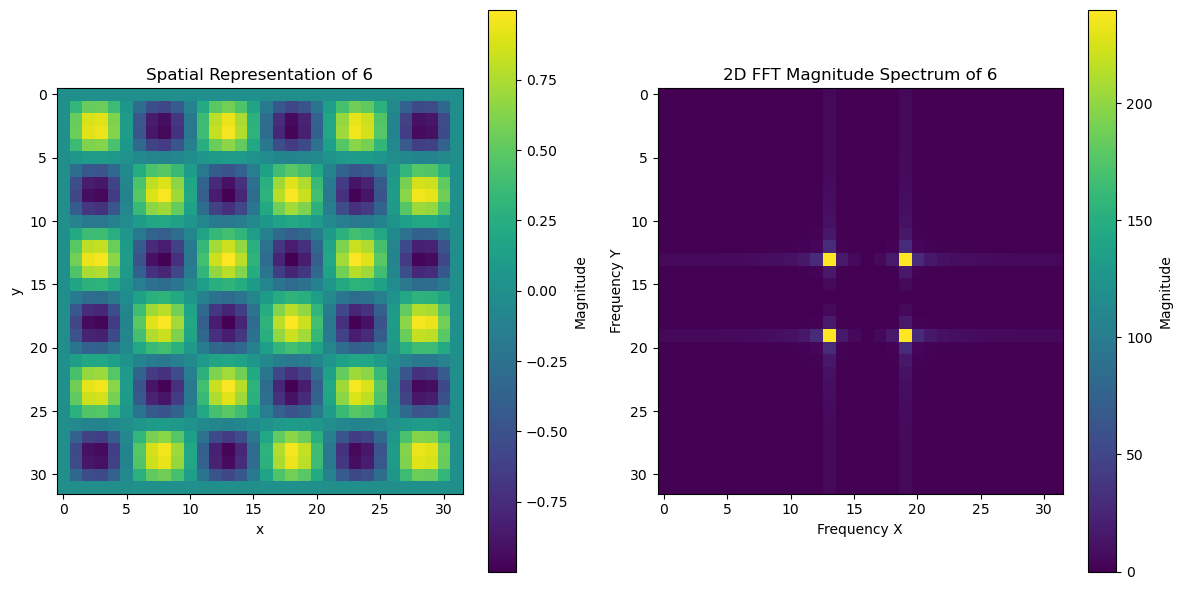

In [3]:
# Load and extract data
datafolder_name = ["OUTPUT", "discrete_symmetric_p32_n400_rs0"]
data_path = os.path.join(*datafolder_name)
print(data_path)

designs, design_params, n_designs, n_panes, design_res, WAVEVECTOR_DATA, WAVEFORM_DATA, n_dim, n_wavevectors, EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x, EIGENVECTOR_DATA_y, const, N_struct, imag_tol, rng_seed_offset = NO_utils.extract_data(data_path)

#Convert all bands to spatial domain
bands = np.arange(1, n_bands + 1)
bands_fft = np.zeros((n_bands, design_res, design_res))
for i, band in enumerate(bands):
    bands_fft[i], _ = NO_utils.const_to_spatial(band, design_res, plot_result=True, scaling_factor=1.0)

#Take unique subset of waveforms    
waveforms = WAVEFORM_DATA[0]

In [4]:
# Draw a random design and its corresponding eigenvectors
random_seed = 18
random.seed(random_seed)
sample_index = np.random.randint(0, n_designs)
sample_geometry = designs[sample_index, 0]
sample_band = np.random.randint(0, n_bands)
sample_wavevector = np.random.randint(0, n_wavevectors)
sample_waveform = WAVEFORM_DATA[sample_index, sample_wavevector]
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_wavevector}')

Design: 198, Band: 4, Wavevector: 250


designs shape: (400, 3, 32, 32)
WAVEFORM_DATA shape: (400, 325, 32, 32)
Average pixel values of all geometries: 0.494375
Average pixel values of all waveforms: 0.7354731009461464


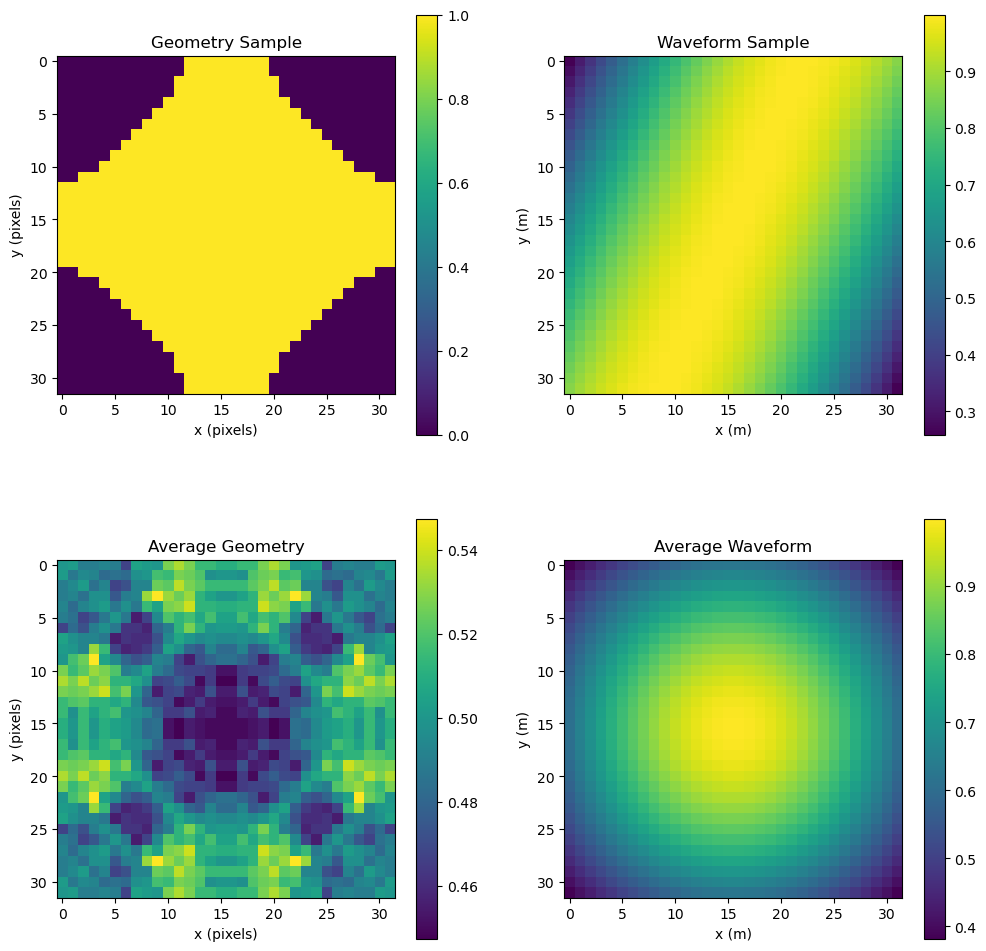

In [5]:
# Calculate the average values for geometry and waveform across all samples
print(f'designs shape: {designs.shape}')
print(f'WAVEFORM_DATA shape: {WAVEFORM_DATA.shape}')

avg_geometry = np.mean(designs[:, 0], axis=0)
avg_waveform = np.mean(WAVEFORM_DATA[0,:], axis=0)

# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the geometry sample on the top-left
im1 = axes[0, 0].imshow(sample_geometry, cmap='viridis')
axes[0, 0].set_title('Geometry Sample')
axes[0, 0].set_xlabel('x (pixels)')
axes[0, 0].set_ylabel('y (pixels)')
plt.colorbar(im1, ax=axes[0, 0])

# Plot the waveform sample on the top-right
im2 = axes[0, 1].imshow(sample_waveform, cmap='viridis')
axes[0, 1].set_title('Waveform Sample')
axes[0, 1].set_xlabel('x (m)')
axes[0, 1].set_ylabel('y (m)')
plt.colorbar(im2, ax=axes[0, 1])

# Plot the average geometry on the bottom-left
im3 = axes[1, 0].imshow(avg_geometry, cmap='viridis')
axes[1, 0].set_title('Average Geometry')
axes[1, 0].set_xlabel('x (pixels)')
axes[1, 0].set_ylabel('y (pixels)')
plt.colorbar(im3, ax=axes[1, 0])

# Plot the average waveform on the bottom-right
im4 = axes[1, 1].imshow(avg_waveform, cmap='viridis')
axes[1, 1].set_title('Average Waveform')
axes[1, 1].set_xlabel('x (m)')
axes[1, 1].set_ylabel('y (m)')
plt.colorbar(im4, ax=axes[1, 1])

print(f'Average pixel values of all geometries: {np.mean(designs[:,0])}')
print(f'Average pixel values of all waveforms: {np.mean(WAVEFORM_DATA[0,:])}')

Design: 198, Band: 4, Wavevector: 250


A:\Research\Projects\NO 2D Metamaterials\NO_utils.py:169: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


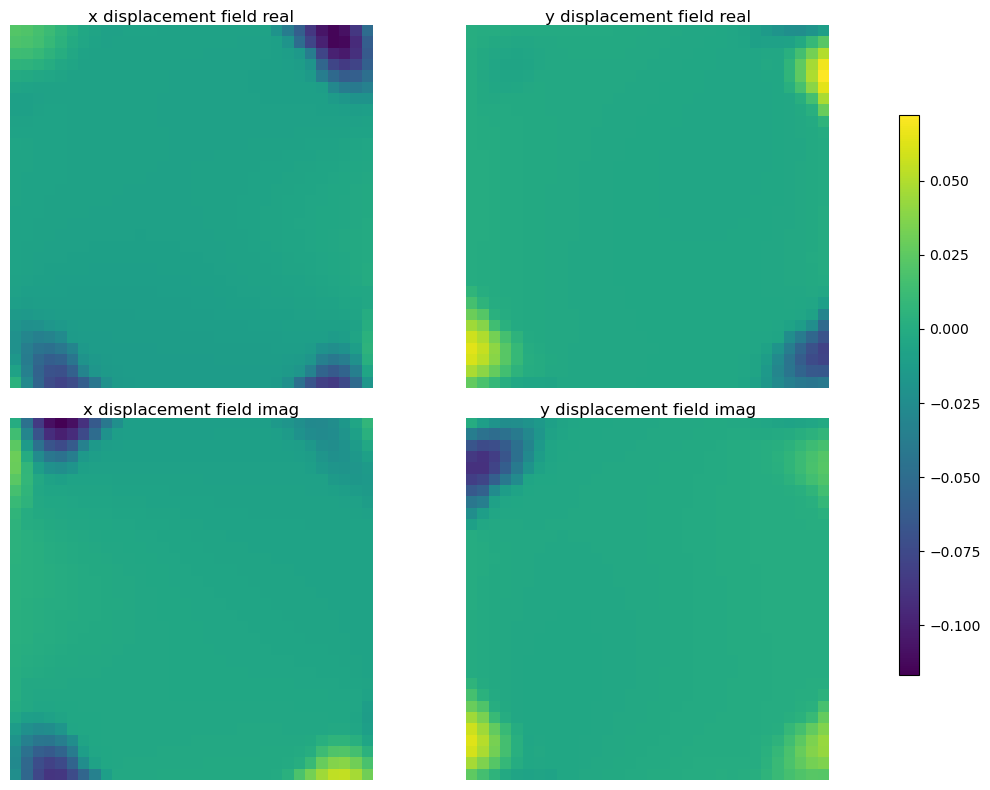

In [6]:
# View eigenvectors for the selected design, band, and wavevector
print(f'Design: {sample_index}, Band: {sample_band}, Wavevector: {sample_wavevector}')
sample_eigenvector_x = EIGENVECTOR_DATA_x[sample_index, sample_wavevector, sample_band]
sample_eigenvector_y = EIGENVECTOR_DATA_y[sample_index, sample_wavevector, sample_band]

NO_utils.plot_eigenvectors(sample_eigenvector_x, sample_eigenvector_y, unify_scales=True)

## Model architecture & training

In [7]:
# Import modules for building a neural operator model
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# Import specialized neural operator model tools
from neuralop.models import FNO, TFNO, FNO2d, TFNO2d
from neuralop import Trainer
from neuralop.training import CheckpointCallback
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.datasets import data_transforms
from neuralop import LpLoss, H1Loss

# For creating datasets and data loaders for training and evaluation
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# Optional: torchvision for augmentations and transformations (if working with image-like data)
import torchvision.transforms as transforms

# For plotting and visualization
import matplotlib.pyplot as plt

# Optional: Use tqdm for progress bars during training and evaluation
from tqdm import tqdm

# Optional: If you are working with graph data or architectures
# import torch_geometric

# If you need automatic differentiation for custom operations or gradients
from torch.autograd import Function

In [8]:
#Set the device for the neural operator model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print("Using PyTorch version:", torch.__version__)

Using Device: cuda
Using PyTorch version: 2.1.0


In [9]:
# Print the shape of the first input tensor for confirmation
print("Shape of the first input tensor to be assigned:")
print("designs[0, 0]:", designs[0, 0].shape)
print("WAVEFORM_DATA[0, 0]:", WAVEFORM_DATA[0, 0].shape)

# Print the shape of the first output tensor for confirmation
print("Shape of the first output tensor to be assigned:")
print("EIGENVECTOR_DATA_x[0, 0, 0]:", EIGENVECTOR_DATA_x[0, 0, 0].shape)
print("EIGENVECTOR_DATA_x[0, 0, 0]:", EIGENVECTOR_DATA_y[0, 0, 0].shape)

Shape of the first input tensor to be assigned:
designs[0, 0]: (32, 32)
WAVEFORM_DATA[0, 0]: (32, 32)
Shape of the first output tensor to be assigned:
EIGENVECTOR_DATA_x[0, 0, 0]: (32, 32)
EIGENVECTOR_DATA_x[0, 0, 0]: (32, 32)


In [10]:
# Prepare input and output data
num_samples = n_designs * n_wavevectors * n_bands
input_data = torch.zeros((num_samples, 3, design_res, design_res))
output_data = torch.zeros((num_samples, 4, design_res, design_res))

sample_idx = 0
for i in range(n_designs):
    for j in range(n_wavevectors):
        for k in range(n_bands):

            input_data[sample_idx, 0] = torch.from_numpy(designs[i, 0])
            input_data[sample_idx, 1] = torch.from_numpy(waveforms[j])
            input_data[sample_idx, 2] = torch.from_numpy(bands_fft[k])

            output_data[sample_idx, 0] = torch.from_numpy(EIGENVECTOR_DATA_x[i, j, k].real)
            output_data[sample_idx, 1] = torch.from_numpy(EIGENVECTOR_DATA_x[i, j, k].imag)
            output_data[sample_idx, 2] = torch.from_numpy(EIGENVECTOR_DATA_y[i, j, k].real)
            output_data[sample_idx, 3] = torch.from_numpy(EIGENVECTOR_DATA_y[i, j, k].imag)

            sample_idx += 1

# Create dataset
dataset = TensorDataset(input_data, output_data)

# Split dataset into train, test, and validation sets
train_size = int(0.75 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 585000
Test dataset size: 156000
Validation dataset size: 39000


In [ ]:
# Scatter plots for the distribution of pixel values for across each input pane.

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for i in range(3):
    axes[i].hist(input_data[:, i].flatten(), bins=100, color='blue', alpha=0.7)
    axes[i].set_title(f'Input Pane {i+1}')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()

# Scatter plots for the distribution of pixel values for across each output component.

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes = axes.flatten()

for i in range(4):
    axes[i].hist(output_data[:, i].flatten(), bins=100, color='green', alpha=0.7)
    axes[i].set_title(f'Output Component {i+1}')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')
    

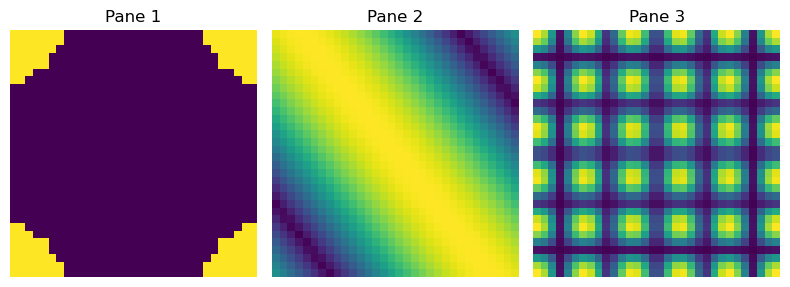

In [11]:
# Visualize a random sample input from the dataset
random_idx = np.random.randint(0, len(dataset))
random_input, random_output = dataset[random_idx]
input_shape = random_input.shape

fig, axes = plt.subplots(1, input_shape[0], figsize=(8, 8))
axes = axes.flatten()

for i in range(3):
    if i == 0:
        img = random_input[i].numpy()
    else:
        img = random_input[i].abs().numpy()
    axes[i].imshow(img, cmap='viridis')
    axes[i].set_title(f'Pane {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

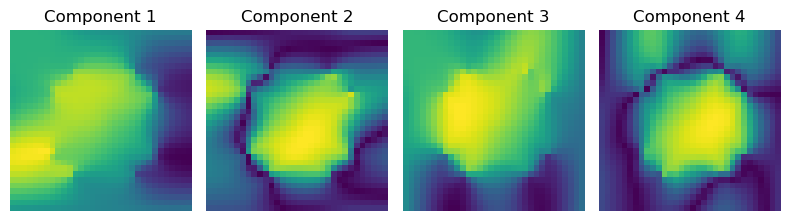

In [12]:
# Visualize a random sample output from the dataset
output_shape = random_output.shape

fig, axes = plt.subplots(1, output_shape[0], figsize=(8, 8))
axes = axes.flatten()

for i in range(4):
    if i % 2 == 0:
        img = random_output[i].numpy()
    else:
        img = random_output[i].abs().numpy()
    axes[i].imshow(img, cmap='viridis')
    axes[i].set_title(f'Component {i+1}')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

In [22]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [23]:
# Print the shapes of the input and output data, train, test, and validation sets
print('Input data shape:', input_data.shape)
print('Output data shape:', output_data.shape)
print('Train data size:', len(train_dataset))
print('Test data size:', len(test_dataset))
print('Validation data size:', len(val_dataset))

# Inspect the first batch of data
for sample in train_loader:
    print('Batch shape:', sample[0].shape, sample[1].shape)
    #print(sample)
    break

Input data shape: torch.Size([780000, 3, 32, 32])
Output data shape: torch.Size([780000, 4, 32, 32])
Train data size: 585000
Test data size: 156000
Validation data size: 39000
Batch shape: torch.Size([256, 3, 32, 32]) torch.Size([256, 4, 32, 32])


In [15]:
class FourierNeuralOperator(nn.Module):
    def __init__(self, modes_height, modes_width, in_channels=3, out_channels=4, hidden=256):
        super(FourierNeuralOperator, self).__init__()
        self.modes_height = modes_height  # Number of Fourier modes in height dimension
        self.modes_width = modes_width  # Number of Fourier modes in width dimension
        self.hidden = hidden  # Width of the hidden channels
        self.in_channels = in_channels  # Number of input channels
        self.out_channels = out_channels  # Number of output channels

        # FNO2d layer
        self.fno = FNO2d(in_channels=self.in_channels, out_channels=self.out_channels,
                         n_modes_height=self.modes_height, n_modes_width=self.modes_width,
                         hidden_channels=self.hidden, num_layers=4)

    def forward(self, x):
        # Apply the FNO2d layer
        x = self.fno(x)
        return x

In [24]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, report_freq=100):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Print progress for each batch
        if (batch_idx + 1) % report_freq == 0 or (batch_idx + 1) == total_batches:
            print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{total_batches}, Batch Loss: {loss.item()}")

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Function to save the model weights
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

# Function to load the model weights
def load_model(model, file_path):
    model.load_state_dict(torch.load(file_path))

In [25]:
model = FourierNeuralOperator(modes_height=design_res, modes_width=design_res, in_channels=3, out_channels=4, hidden=128).to(device)

# Define the loss function
criterion = nn.MSELoss()  # Using MSELoss for stability
# Define the optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
# Define the learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [26]:
# Single batch data check
inputs, targets = next(iter(train_loader))
inputs, targets = inputs.to(device), targets.to(device)
print(f"Input range: min={inputs.min().item()}, max={inputs.max().item()}")
print(f"Target range: min={targets.min().item()}, max={targets.max().item()}")

outputs = model(inputs)
print(f"Output range: min={outputs.min().item()}, max={outputs.max().item()}")

loss = criterion(outputs, targets).mean()  # Ensure the loss is a scalar
if torch.isnan(loss).any() or torch.isinf(loss).any():
    print("Loss is NaN or Inf.")

    # Check if any values in outputs or targets are NaN or Inf
    if torch.isnan(outputs).any() or torch.isinf(outputs).any():
        print("Problematic Output Values:")
        print(outputs[torch.isnan(outputs) | torch.isinf(outputs)])  # Print problematic values directly

    if torch.isnan(targets).any() or torch.isinf(targets).any():
        print("Problematic Target Values:")
        print(targets[torch.isnan(targets) | torch.isinf(targets)])  # Print problematic values directly

else:
    print(f"Loss: {loss.item()}")

Input range: min=-1.0, max=1.0
Target range: min=-0.432373046875, max=0.490234375


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Of the allocated memory 20.86 GiB is allocated by PyTorch, and 1.44 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [27]:
# Parameters for saving/loading model weights
save_path = './model_weights.pth'
load_existing_model = False  # Set to True if you want to load an existing model

# Load the model weights if a valid file path is provided and the flag is set
if load_existing_model and os.path.isfile(save_path):
    load_model(model, save_path)
    print(f"Loaded model weights from {save_path}")

In [28]:
# Lists to store losses for plotting
train_losses = []
val_losses = []

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, report_freq=100)
    val_loss = evaluate(model, val_loader, criterion, device)

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}")

    # Save losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Step the scheduler
    scheduler.step(val_loss)

# Plot the losses
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot

Epoch 1, Batch 100/2286, Batch Loss: 3468155648.0
Epoch 1, Batch 200/2286, Batch Loss: 251743760.0
Epoch 1, Batch 300/2286, Batch Loss: 335254048.0
Epoch 1, Batch 400/2286, Batch Loss: 40801944.0
Epoch 1, Batch 500/2286, Batch Loss: 7708553.0
Epoch 1, Batch 600/2286, Batch Loss: 257048784.0
Epoch 1, Batch 700/2286, Batch Loss: 35993396.0
Epoch 1, Batch 800/2286, Batch Loss: 27962558.0
Epoch 1, Batch 900/2286, Batch Loss: 21758750.0
Epoch 1, Batch 1000/2286, Batch Loss: 25278044.0
Epoch 1, Batch 1100/2286, Batch Loss: 16031948.0
Epoch 1, Batch 1200/2286, Batch Loss: 66171472.0
Epoch 1, Batch 1300/2286, Batch Loss: 24524286.0
Epoch 1, Batch 1400/2286, Batch Loss: 11763493.0
Epoch 1, Batch 1500/2286, Batch Loss: 10608278.0
Epoch 1, Batch 1600/2286, Batch Loss: 9092998.0
Epoch 1, Batch 1700/2286, Batch Loss: 8010141.0
Epoch 1, Batch 1800/2286, Batch Loss: 12226752.0
Epoch 1, Batch 1900/2286, Batch Loss: 8173496.0
Epoch 1, Batch 2000/2286, Batch Loss: 55138600.0
Epoch 1, Batch 2100/2286, Ba

In [ ]:
# Save the model weights at the end of training
save_model(model, save_path)
print(f"Saved model weights to {save_path}")

In [ ]:
def plot_sample(data, title, labels, shared_colorbar=False):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    if shared_colorbar:
        # Compute global min and max for the shared colorbar
        vmin = np.min(data.cpu().numpy())
        vmax = np.max(data.cpu().numpy())

    for ax, (idx, label) in zip(axes.flatten(), labels):
        im = ax.imshow(data[idx, :, :].cpu(), cmap='viridis', vmin=vmin if shared_colorbar else None, vmax=vmax if shared_colorbar else None)
        ax.set_title(label)
        if not shared_colorbar:
            fig.colorbar(im, ax=ax)

    if shared_colorbar:
        # Add a single colorbar to the right of the plot
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
        cbar.ax.set_ylabel('Color scale')

    plt.suptitle(title)
    plt.show()

def plot_predictions_and_targets(inputs, outputs, targets):
    input_labels = [(0, 'geometry'), (3, 'band'), (1, 'wavevector_x'), (2, 'wavevector_y')]
    plot_sample(inputs, "Input Sample", input_labels, shared_colorbar=True)

    prediction_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(outputs, "Model Predictions", prediction_labels, shared_colorbar=True)

    target_labels = [(0, 'eigenvector_x_real'), (1, 'eigenvector_x_imag'), (2, 'eigenvector_y_real'), (3, 'eigenvector_y_imag')]
    plot_sample(targets, "Target Values", target_labels, shared_colorbar=True)

# Get a batch from the validation loader
inputs, targets = next(iter(val_loader))
inputs, targets = inputs.to(device), targets.to(device)

# Get a single sample from the batch
input_sample = inputs[0]
target_sample = targets[0]

# Run the model to get predictions
model.eval()
with torch.no_grad():
    output_sample = model(input_sample.unsqueeze(0)).squeeze(0)

# Plot the inputs, predictions, and targets
plot_predictions_and_targets(input_sample, output_sample, target_sample)
